# 🔬 Feature Selection with Binomial Deviance

To reduce dimensionality and retain informative biological signals, we select a subset of highly deviant genes using the `scry` R package. This method avoids the biases introduced by log-transformation and pseudo-counts.


In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scanpy as sc

import rpy2.robjects as ro
import rpy2.rinterface_lib.callbacks as rcb
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# 📥 Load normalized dataset
adata = sc.read("../../data/processed/breast_cancer_dimred.h5ad")

# 📦 R interface settings
rcb.logger.setLevel(logging.ERROR)
pandas2ri.activate()

# 👇 Required to use %%R magic
%load_ext rpy2.ipython


## 📊 Identify Highly Deviant Genes with `scry` in R


In [2]:
from scipy.sparse import issparse
import rpy2.robjects as ro

# Extract gene-by-cell matrix
raw_counts = adata.X.T  # transpose to match R format (genes x cells)

# Convert to dense if needed
if issparse(raw_counts):
    raw_counts = raw_counts.toarray()

# Send to R
ro.globalenv["raw_counts"] = raw_counts

ro.globalenv["gene_names"] = adata.var_names.to_list()
ro.globalenv["cell_names"] = adata.obs_names.to_list()


In [3]:
%%R
library(scry)
library(SingleCellExperiment)

# Create SingleCellExperiment
sce <- SingleCellExperiment(list(counts = raw_counts))

# Optional: assign row/colnames
rownames(sce) <- gene_names
colnames(sce) <- cell_names

# Run deviance feature selection
sce <- devianceFeatureSelection(sce)
binomial_deviance <- rowData(sce)$binomial_deviance


## 🧬 Select Top 4000 Highly Deviant Genes


In [5]:
# 🧬 Auto-select number of genes to keep (replaces the "top 4000" block)

import numpy as np

# binomial_deviance already exists; adata is loaded
binomial_deviance = np.array(ro.r("binomial_deviance"))


def choose_k_from_deviance(dev, n_cells, frac=0.85, k_default=4000,
                           k_min=2000, k_max=None):
    dev = np.nan_to_num(np.asarray(dev).ravel(), nan=0.0, posinf=0.0, neginf=0.0)
    dev_sorted = np.sort(dev)[::-1]
    n_genes = dev_sorted.size

    # 1) cumulative deviance ≥ frac
    cum = np.cumsum(dev_sorted)
    total = cum[-1] if cum[-1] > 0 else 1.0
    k_cum = int(np.searchsorted(cum / total, frac)) + 1

    # 2) knee (distance to chord on normalized curve)
    y = (dev_sorted - dev_sorted.min()) / (dev_sorted.max() - dev_sorted.min() + 1e-12)
    x = np.linspace(0, 1, n_genes)
    dist = x + y - 1.0
    k_knee = int(np.argmax(dist)) + 1

    # practical bounds
    if k_max is None:
        k_max = int(min(10000, max(1000, 0.25 * n_cells)))

    k_final = int(np.median([k_cum, k_knee, k_default]))
    k_final = max(k_min, min(k_final, k_max, n_genes))
    return k_final, {"k_cum": k_cum, "k_knee": k_knee, "k_default": k_default,
                     "k_min": k_min, "k_max": k_max, "frac": frac}

# pick K
K, info = choose_k_from_deviance(binomial_deviance, n_cells=adata.n_obs, frac=0.85)
print(f"Auto-selected K={K} (cum={info['k_cum']}, knee={info['k_knee']}, "
      f"default={info['k_default']}, bounds=[{info['k_min']},{info['k_max']}], frac={info['frac']})")

# mark top-K genes
idx = np.argpartition(binomial_deviance, -K)[-K:]
mask = np.zeros(adata.n_vars, dtype=bool); mask[idx] = True
adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = np.asarray(binomial_deviance).ravel()


Auto-selected K=4000 (cum=11091, knee=1, default=4000, bounds=[2000,7630], frac=0.85)


## 🧪 Compare to Scanpy's Mean/Dispersion Metrics


In [6]:
sc.pp.highly_variable_genes(adata, layer="scran_normalization")


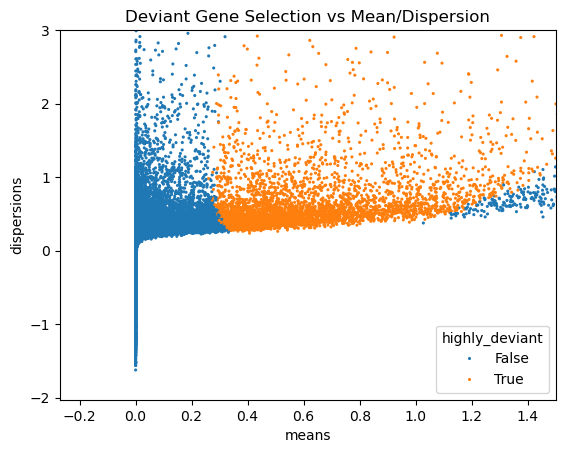

In [7]:
ax = sns.scatterplot(
    data=adata.var,
    x="means", y="dispersions",
    hue="highly_deviant", s=5, linewidth=0
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.title("Deviant Gene Selection vs Mean/Dispersion")
plt.show()


## 💾 Save Feature-Selected Dataset


In [8]:
adata.write("../../data/breast_cancer_feature_selection.h5ad")
print("✅ Saved to 'breast_cancer_feature_selection.h5ad'")


✅ Saved to 'breast_cancer_feature_selection.h5ad'


### Feature Selection via Deviance
We applied binomial deviance-based feature selection using the `scry` R package. This method identifies genes that show significant variability across cells, avoiding the biases of pseudo-count log-transformation. The top 4000 most deviant genes were marked and used for downstream dimensionality reduction and clustering.
